In [1]:
%matplotlib inline
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


# 1. Extract the AO Robustly from Images

## a. Implement at Least Two Methods for AO Extraction (10%)

In [2]:
img = cv2.imread('/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/Dataset_25/Easy/images/000016.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
def crop_with_mask(img, mask, box):
    (x1, y1, x2, y2) = box

    # Crop image + crop mask
    cropped = img[y1:y2, x1:x2]
    mask_crop = mask[y1:y2, x1:x2]

    # White background outside the mask
    cropped_white = cropped.copy()
    cropped_white[mask_crop == 0] = [255, 255, 255]

    # Place back into white canvas
    canvas = np.ones_like(img) * 255
    canvas[y1:y2, x1:x2] = cropped_white

    return canvas

In [4]:
def hough_circle_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,
        param1=50,
        param2=30,
        minRadius=300,
        maxRadius=400
    )

    # Create empty mask
    mask = np.zeros_like(gray)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]

        # Draw mask
        cv2.circle(mask, (x, y), r, 255, -1)

        # Bounding box
        x1 = max(x - r, 0)
        y1 = max(y - r, 0)
        x2 = min(x + r, img.shape[1])
        y2 = min(y + r, img.shape[0])

    else:
        # No circle found → return full white?
        mask[:] = 0
        x1, y1, x2, y2 = 0, 0, img.shape[1], img.shape[0]

    return mask, (x1, y1, x2, y2)

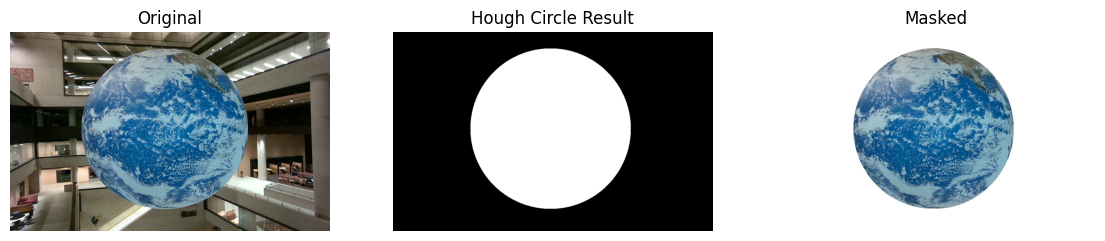

In [5]:
cropped_mask, box = hough_circle_mask(img)
canvas = crop_with_mask(img, cropped_mask, box)

plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")


plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB))
plt.title("Hough Circle Result")
plt.axis("off")


plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")

plt.show()

In [6]:
def color_threshold_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([55, 15, 40])
    upper_blue = np.array([150, 255, 210])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    lower_white = np.array([90, 5, 180])
    upper_white = np.array([100, 15, 190])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    mask = cv2.bitwise_or(mask_blue, mask_white)

    kernel = np.ones((15, 15), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_clean, connectivity=4)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    earth_mask = (labels == largest_label).astype(np.uint8) * 255

    x, y, w, h, area = stats[largest_label]
    x1, y1 = x, y
    x2, y2 = x + w, y + h

    return earth_mask, (x1, y1, x2, y2)

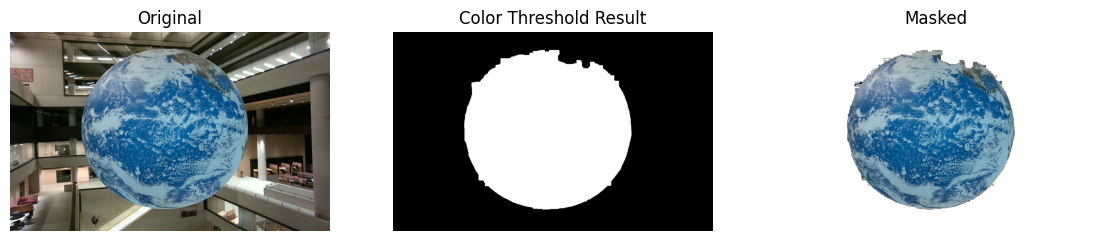

In [7]:
cropped_mask, box = color_threshold_mask(img)
canvas = crop_with_mask(img, cropped_mask, box)


plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")


plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB))
plt.title("Color Threshold Result")
plt.axis("off")


plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")

plt.show()

## b. Combine Methods for Improved Accuracy (5%)

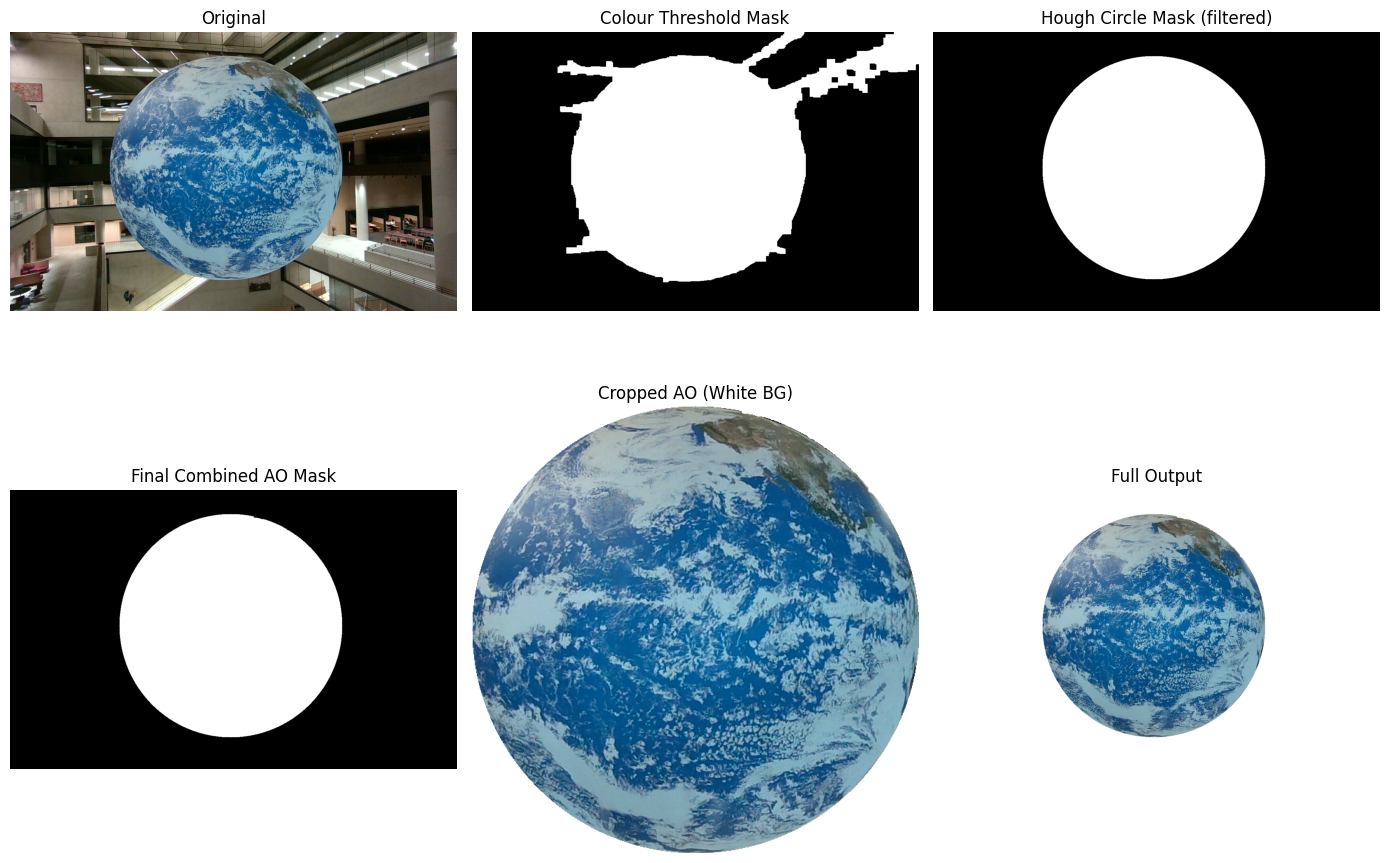

In [ ]:

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_blue = np.array([80, 10, 0])
upper_blue = np.array([250, 300, 250])
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

lower_white = np.array([0, 1, 0])
upper_white = np.array([100, 35, 200])
mask_white = cv2.inRange(hsv, lower_white, upper_white)

mask_color = cv2.bitwise_or(mask_blue, mask_white)


kernel = np.ones((15, 15), np.uint8)
mask_clean = cv2.morphologyEx(mask_color, cv2.MORPH_CLOSE, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_clean, connectivity=4)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
mask_blob = (labels == largest_label).astype(np.uint8) * 255


img_filtered = cv2.bitwise_and(img, img, mask=mask_blob)


gray_filtered = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(
    gray_filtered, cv2.HOUGH_GRADIENT, dp=1, minDist=80,
    param1=50, param2=20,
    minRadius=300, maxRadius=400
)

mask_hough = np.zeros_like(gray_filtered, dtype=np.uint8)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    x, y, r = circles[0]

    cv2.circle(mask_hough, (x, y), r, 255, -1)

else:
    mask_hough = mask_blob.copy()


final_mask = cv2.bitwise_and(mask_blob, mask_hough)


ys, xs = np.where(final_mask > 0)
x1, x2 = xs.min(), xs.max()
y1, y2 = ys.min(), ys.max()

cropped = img[y1:y2, x1:x2]
cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
cropped_mask = final_mask[y1:y2, x1:x2]

cropped_white = cropped_rgb.copy()
cropped_white[cropped_mask == 0] = [255, 255, 255]

canvas = np.ones_like(img_rgb) * 255
canvas[y1:y2, x1:x2] = cropped_white

cv2.imwrite("final_mask.png", final_mask)

plt.figure(figsize=(14,10))

plt.subplot(2,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(mask_blob, cmap="gray")
plt.title("Colour Threshold Mask")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(mask_hough, cmap="gray")
plt.title("Hough Circle Mask (filtered)")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(final_mask, cmap="gray")
plt.title("Final Combined AO Mask")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(cropped_white)
plt.title("Cropped AO (White BG)")
plt.axis("off")

plt.subplot(2,3,6)
plt.imshow(canvas)
plt.title("Full Output")
plt.axis("off")

plt.tight_layout()
plt.show()

## c. Evaluate Performance with ROC Curves (5%)

In [27]:
def roc_param(gt_mask, pred_mask):
    gt = (gt_mask > 127).astype(np.uint8)
    pred = (pred_mask > 127).astype(np.uint8)

    tp = np.logical_and(pred == 1, gt == 1)

    tn = np.logical_and(pred == 0, gt == 0)

    fp = np.logical_and(pred == 1, gt == 0)

    fn = np.logical_and(pred == 0, gt == 1)


    overlay = np.zeros_like(img_rgb, dtype=np.uint8)  

    overlay[tp] = [135, 206, 250]      
    overlay[fp] = [255, 105, 180]     
    overlay[fn] = [0, 255, 0]  

    tp = len(overlay[tp])
    tn = len(overlay[tn])
    fp = len(overlay[fp])
    fn = len(overlay[fn])

    return overlay, tp, tn, fp, fn

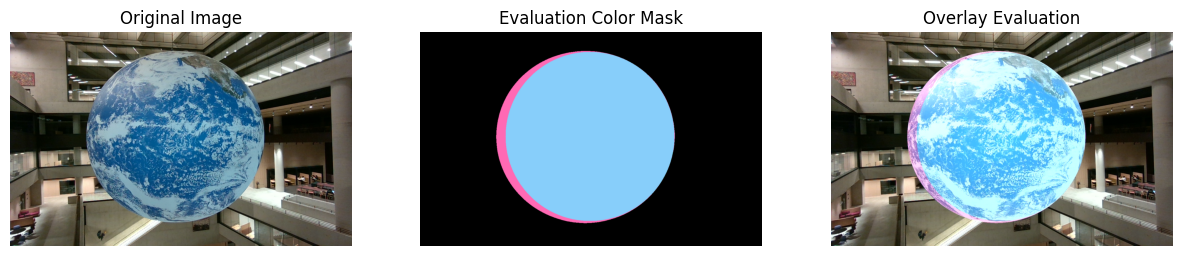

In [28]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pred_mask = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/ground_truth_masks/000016.png", cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/method_1_mask.png", cv2.IMREAD_GRAYSCALE)

overlay, tp, tn, fp, fn = roc_param(gt_mask, pred_mask)

alpha = 0.5  
overlayed = cv2.addWeighted(img_rgb, 1, overlay, alpha, 0)


plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(overlay)
plt.title("Evaluation Color Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlayed)
plt.title("Overlay Evaluation")
plt.axis("off")

plt.show()

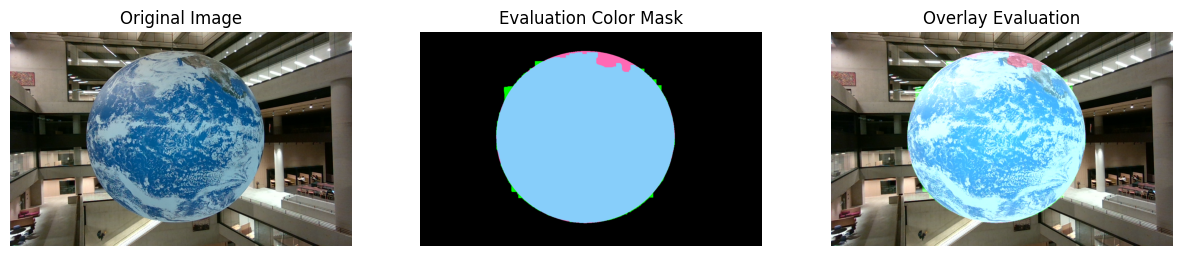

In [ ]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gt_mask = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/method_2_mask.png", cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/Dataset_25/Easy/masks/000016.png", cv2.IMREAD_GRAYSCALE)


gt = (gt_mask > 127).astype(np.uint8)
pred = (pred_mask > 127).astype(np.uint8)

tp = np.logical_and(pred == 1, gt == 1)

fp = np.logical_and(pred == 1, gt == 0)

fn = np.logical_and(pred == 0, gt == 1)


overlay = np.zeros_like(img_rgb, dtype=np.uint8)  

alpha = 0.5  
overlayed = cv2.addWeighted(img_rgb, 1, overlay, alpha, 0)

plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(overlay)
plt.title("Evaluation Color Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlayed)
plt.title("Overlay Evaluation")
plt.axis("off")

plt.show()

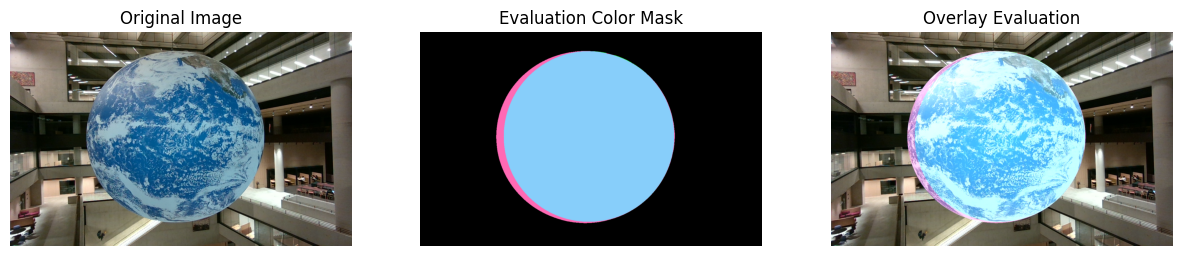

142

In [44]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gt_mask = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/final_mask.png", cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/Dataset_25/Easy/masks/000016.png", cv2.IMREAD_GRAYSCALE)


gt = (gt_mask > 127).astype(np.uint8)
pred = (pred_mask > 127).astype(np.uint8)

tp = np.logical_and(pred == 1, gt == 1)

fp = np.logical_and(pred == 1, gt == 0)

fn = np.logical_and(pred == 0, gt == 1)


overlay = np.zeros_like(img_rgb, dtype=np.uint8)

overlay[tp] = [135, 206, 250]      
overlay[fp] = [255, 105, 180]      
overlay[fn] = [0, 255, 0]   


alpha = 0.5  
overlayed = cv2.addWeighted(img_rgb, 1, overlay, alpha, 0)

plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(overlay)
plt.title("Evaluation Color Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlayed)
plt.title("Overlay Evaluation")
plt.axis("off")

plt.show()
len(overlay[fn])

In [30]:
from sklearn.metrics import roc_curve, auc

def compute_roc(gt_mask, pred_mask):
    # Convert to 0/1
    gt = (gt_mask > 127).astype(np.uint8)
    pred = (pred_mask > 127).astype(np.uint8)

    # Soft prediction using Distance Transform
    pred_soft = cv2.distanceTransform(pred.astype(np.uint8), cv2.DIST_L2, 5)
    pred_soft = pred_soft / (pred_soft.max() + 1e-6)

    # Flatten
    y_true = gt.flatten()
    y_score = pred_soft.flatten()

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_val = auc(fpr, tpr)

    return fpr, tpr, auc_val

In [31]:
def run_color_method(img):
    mask, box = color_threshold_mask(img)
    return mask

In [32]:
def color_threshold_mask_with_param(img, hue_upper):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Use different H upper value
    lower_blue = np.array([55, 15, 40])
    upper_blue = np.array([hue_upper, 255, 210])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    lower_white = np.array([90, 5, 180])
    upper_white = np.array([100, 15, 190])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    mask = cv2.bitwise_or(mask_blue, mask_white)

    kernel = np.ones((15, 15), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_clean, connectivity=4)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    earth_mask = (labels == largest_label).astype(np.uint8) * 255

    return earth_mask

In [33]:
import matplotlib.pyplot as plt

def plot_roc_for_color(img, gt_mask):
    hue_values = range(90, 160, 5)   # vary parameter

    plt.figure(figsize=(8,6))

    for hue in hue_values:
        pred_mask = color_threshold_mask_with_param(img, hue)
        fpr, tpr, auc_val = compute_roc(gt_mask, pred_mask)
        plt.plot(fpr, tpr, label=f"H upper={hue}, AUC={auc_val:.3f}")

    plt.title("ROC Curve for Color Thresholding (vary hue upper)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

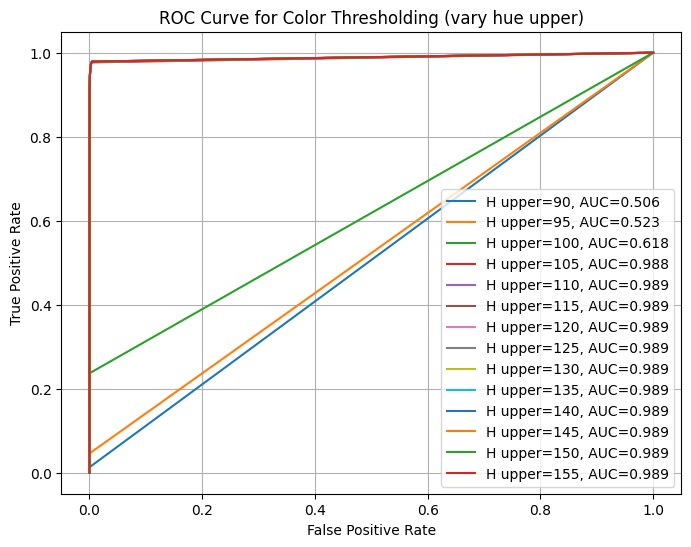

In [34]:
img = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/Dataset_25/Easy/images/000016.png")
gt_mask = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/Dataset_25/Easy/masks/000016.png", cv2.IMREAD_GRAYSCALE)

plot_roc_for_color(img, gt_mask)

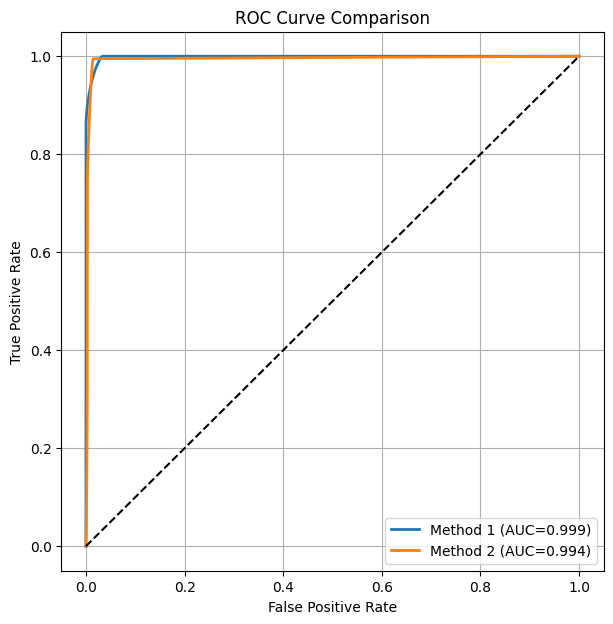

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def load_and_compute_roc(gt_path, gt):
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    gt = (gt_mask > 127).astype(np.uint8)
    pred = (pred_mask > 127).astype(np.uint8)


    pred_soft = cv2.distanceTransform(pred.astype(np.uint8), cv2.DIST_L2, 5)
    pred_soft = pred_soft / (pred_soft.max() + 1e-6)  

    y_true = gt.flatten()
    y_score = pred_soft.flatten()

    fpr, tpr, thresh = roc_curve(y_true, y_score)
    auc_val = auc(fpr, tpr)

    return fpr, tpr, auc_val



fpr1, tpr1, auc1 = load_and_compute_roc(
    "/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/method_1_mask.png",
    "/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/Dataset_25/Easy/masks/000016.png"
)

fpr2, tpr2, auc2 = load_and_compute_roc(
    "/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/method_2_mask.png",
    "/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/Dataset_25/Easy/masks/000016.png"
)


plt.figure(figsize=(7,7))
plt.plot(fpr1, tpr1, lw=2, label=f"Method 1 (AUC={auc1:.3f})")
plt.plot(fpr2, tpr2, lw=2, label=f"Method 2 (AUC={auc2:.3f})")
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

# 2C

In [48]:
from functions import dynamicProgram, dynamicProgramVec

In [50]:
im1 = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/stereo/calibration_image_00_cam2.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float32)
im2 = cv2.imread("/Users/yui/Desktop/Uni/COMP0241/CV_and_Sensing/Final/stereo/calibration_image_00_cam1.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float32)

H = min(im1.shape[0], im2.shape[0])
W = min(im1.shape[1], im2.shape[1])

im1 = im1[:H, :W]
im2 = im2[:H, :W]

imY, imX = im1.shape

maxDisp = 100
alpha = 6
noiseSD = 50

pairwiseCosts = alpha * np.ones((maxDisp, maxDisp)) - alpha * np.eye(maxDisp)

estDisp = np.zeros((imY, imX - maxDisp))


for y in range(imY):
    unaryCosts = np.zeros((maxDisp, imX - maxDisp))

    for d in range(maxDisp):
        left_line = im1[y, :imX - maxDisp]
        right_line = im2[y, d:(d + imX - maxDisp)]


        diff = left_line - right_line
        unaryCosts[d, :] = (diff**2) / (2 * noiseSD**2)

    estDisp[y, :] = dynamicProgramVec(unaryCosts, pairwiseCosts)


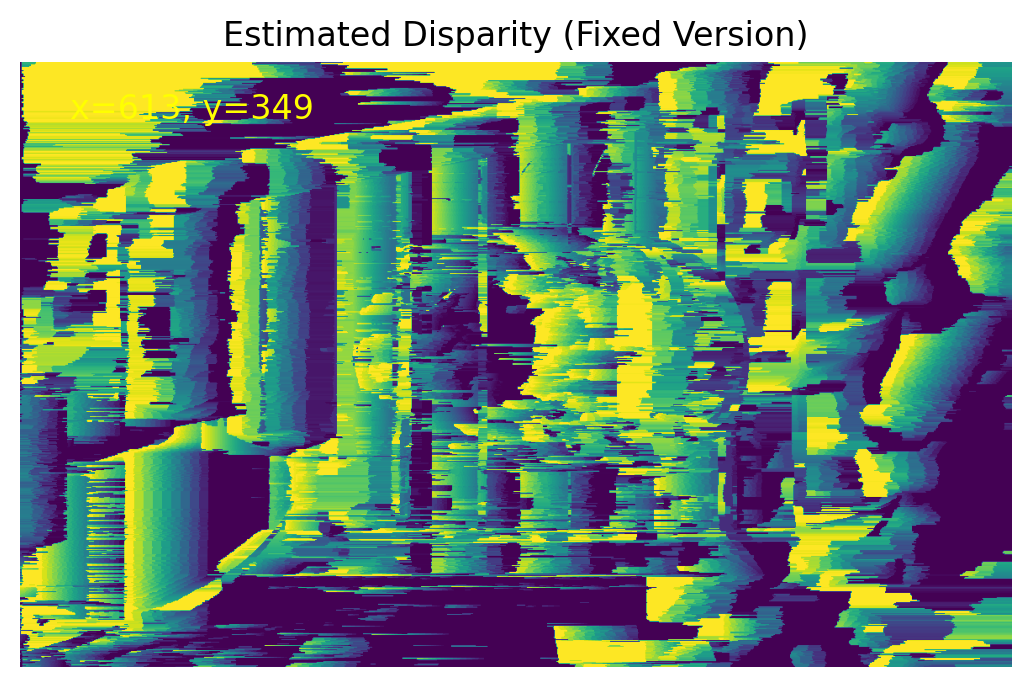

In [31]:
%matplotlib inline
plt.imshow(estDisp)
plt.title("Estimated Disparity (Fixed Version)")
plt.axis("off")
plt.show()

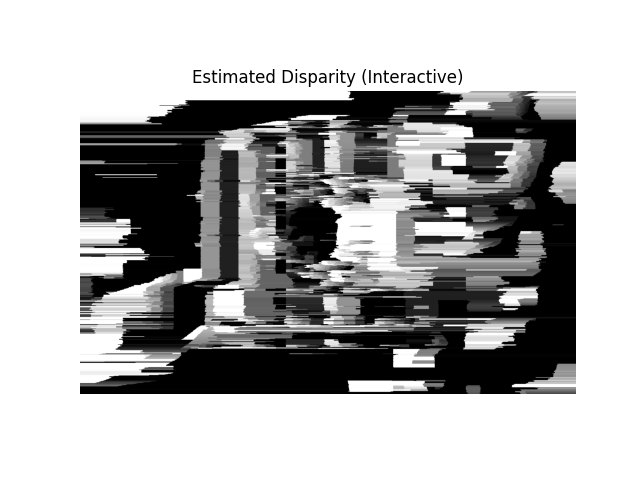

In [51]:
%matplotlib ipympl
import matplotlib.pyplot as plt



fig, ax = plt.subplots()
im = ax.imshow(estDisp, cmap='gray')
plt.title("Estimated Disparity (Interactive)")
plt.axis("off")

text = ax.text(0.05, 0.95, "", color="yellow", fontsize=12,
               transform=ax.transAxes, va="top")

def update_text(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        text.set_text(f"x={x}, y={y}")
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', update_text)
plt.show()

In [52]:
x = 766
y = 344

max_x_disp = estDisp.shape[1]

if x >= max_x_disp:
    print(" x is outside valid disparity range. Use x < ", max_x_disp)
else:
    disp_value = estDisp[y, x]
    print("Water bottle disparity =", disp_value)

Water bottle disparity = 54.0


# Q3
